In [1]:
from datasets import load_dataset
raw_datasets = load_dataset("Helsinki-NLP/opus-100", "en-id")
raw_datasets

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 1000000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})

In [2]:
model_mbart = 'facebook/mbart-large-50-one-to-many-mmt'

from transformers import MBart50TokenizerFast
tokenizer = MBart50TokenizerFast.from_pretrained(model_mbart, src_lang="en_XX", tgt_lang="id_ID")

In [3]:
source_lang = "en"
target_lang = "id"
def preprocess(data):
  inputs = [dt[source_lang] for dt in data["translation"]]
  targets = [dt[target_lang] for dt in data["translation"]]
  model_inputs = tokenizer(inputs, truncation=True)

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(targets, truncation=True)
  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

tokenized_datasets = raw_datasets.map(preprocess, batched=True)

In [4]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(500000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42)

In [5]:
from transformers import MBartForConditionalGeneration, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq, Seq2SeqTrainer, EarlyStoppingCallback
model = MBartForConditionalGeneration.from_pretrained(model_mbart)
model = model.cuda()

In [6]:
# Freeze all layers except the decoder's last layers (adjust as needed)
count = 0
for param in model.get_encoder().parameters():
    param.requires_grad = False
    count+=1

print(f"freezes {count} layers")

freezes 198 layers


In [7]:
args = Seq2SeqTrainingArguments(
   f"mbart-large-50-one-to-many-mmt-finetuned-en-to-id",
   evaluation_strategy = "epoch",
   save_strategy= "epoch",
   learning_rate=3e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   weight_decay=0.01,
   save_total_limit=10,
   num_train_epochs=10,
   predict_with_generate=True,
   load_best_model_at_end= True,
   gradient_accumulation_steps=2,
)

In [8]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [9]:
import numpy as np
import evaluate
metric = evaluate.load("sacrebleu")
meteor = evaluate.load('meteor')

def postprocess_text(preds, labels):
   preds = [pred.strip() for pred in preds]
   labels = [[label.strip()] for label in labels]
   return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels!= -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    meteor_result = meteor.compute(predictions=decoded_preds, references=decoded_labels)
    prediction_lens = [np.count_nonzero(pred!= tokenizer.pad_token_id) for pred in preds]
    result = {'bleu' : result['score']}
    result["gen_len"] = np.mean(prediction_lens)
    result["meteor"] = meteor_result["meteor"]
    result = {k: round(v, 4) for k, v in result.items()}
    return result

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\IBDA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\IBDA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\IBDA\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [10]:
trainer = Seq2SeqTrainer(
   model,
   args,
   train_dataset=small_train_dataset,
   eval_dataset=small_eval_dataset,
   data_collator=data_collator,
   tokenizer=tokenizer,
   compute_metrics=compute_metrics,
   # callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)
trainer.train()

  0%|          | 0/156250 [00:00<?, ?it/s]

{'loss': 2.023, 'grad_norm': 1.9579554796218872, 'learning_rate': 2.9904e-05, 'epoch': 0.03}
{'loss': 1.8929, 'grad_norm': 2.0516369342803955, 'learning_rate': 2.9808000000000003e-05, 'epoch': 0.06}
{'loss': 1.8251, 'grad_norm': 1.7845592498779297, 'learning_rate': 2.9712e-05, 'epoch': 0.1}
{'loss': 1.8119, 'grad_norm': 1.962348461151123, 'learning_rate': 2.9616e-05, 'epoch': 0.13}
{'loss': 1.7804, 'grad_norm': 1.8938285112380981, 'learning_rate': 2.9520000000000002e-05, 'epoch': 0.16}
{'loss': 1.7554, 'grad_norm': 1.9300061464309692, 'learning_rate': 2.9424e-05, 'epoch': 0.19}
{'loss': 1.7344, 'grad_norm': 3.6589744091033936, 'learning_rate': 2.9328e-05, 'epoch': 0.22}
{'loss': 1.7321, 'grad_norm': 2.200183153152466, 'learning_rate': 2.9232e-05, 'epoch': 0.26}
{'loss': 1.6931, 'grad_norm': 1.5904501676559448, 'learning_rate': 2.9136e-05, 'epoch': 0.29}
{'loss': 1.6927, 'grad_norm': 1.6223721504211426, 'learning_rate': 2.904e-05, 'epoch': 0.32}
{'loss': 1.6656, 'grad_norm': 1.781073927

  0%|          | 0/125 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


{'eval_loss': 1.5452399253845215, 'eval_bleu': 29.5254, 'eval_gen_len': 12.504, 'eval_meteor': 0.545, 'eval_runtime': 83.3628, 'eval_samples_per_second': 23.992, 'eval_steps_per_second': 1.499, 'epoch': 1.0}
{'loss': 1.4566, 'grad_norm': 1.7083241939544678, 'learning_rate': 2.6928e-05, 'epoch': 1.02}
{'loss': 1.4424, 'grad_norm': 1.750245213508606, 'learning_rate': 2.6832e-05, 'epoch': 1.06}
{'loss': 1.457, 'grad_norm': 1.6180684566497803, 'learning_rate': 2.6736e-05, 'epoch': 1.09}
{'loss': 1.4547, 'grad_norm': 1.64698326587677, 'learning_rate': 2.6640000000000002e-05, 'epoch': 1.12}
{'loss': 1.4533, 'grad_norm': 1.9983388185501099, 'learning_rate': 2.6544000000000002e-05, 'epoch': 1.15}
{'loss': 1.429, 'grad_norm': 2.390409231185913, 'learning_rate': 2.6448e-05, 'epoch': 1.18}
{'loss': 1.443, 'grad_norm': 1.7640047073364258, 'learning_rate': 2.6351999999999998e-05, 'epoch': 1.22}
{'loss': 1.446, 'grad_norm': 1.6750234365463257, 'learning_rate': 2.6256e-05, 'epoch': 1.25}
{'loss': 1.4

  0%|          | 0/125 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


{'eval_loss': 1.4987502098083496, 'eval_bleu': 30.5962, 'eval_gen_len': 12.6155, 'eval_meteor': 0.5506, 'eval_runtime': 80.3597, 'eval_samples_per_second': 24.888, 'eval_steps_per_second': 1.556, 'epoch': 2.0}
{'loss': 1.3627, 'grad_norm': 1.7072772979736328, 'learning_rate': 2.3952e-05, 'epoch': 2.02}
{'loss': 1.2935, 'grad_norm': 2.289550304412842, 'learning_rate': 2.3856e-05, 'epoch': 2.05}
{'loss': 1.2878, 'grad_norm': 1.9759141206741333, 'learning_rate': 2.3760000000000003e-05, 'epoch': 2.08}
{'loss': 1.2798, 'grad_norm': 1.992641806602478, 'learning_rate': 2.3664e-05, 'epoch': 2.11}
{'loss': 1.3059, 'grad_norm': 1.58208167552948, 'learning_rate': 2.3568e-05, 'epoch': 2.14}
{'loss': 1.2968, 'grad_norm': 1.9404739141464233, 'learning_rate': 2.3472e-05, 'epoch': 2.18}
{'loss': 1.2938, 'grad_norm': 1.9516205787658691, 'learning_rate': 2.3376e-05, 'epoch': 2.21}
{'loss': 1.3128, 'grad_norm': 2.0585696697235107, 'learning_rate': 2.328e-05, 'epoch': 2.24}
{'loss': 1.295, 'grad_norm': 1.

  0%|          | 0/125 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


{'eval_loss': 1.4846129417419434, 'eval_bleu': 30.1748, 'eval_gen_len': 12.5645, 'eval_meteor': 0.5497, 'eval_runtime': 76.7907, 'eval_samples_per_second': 26.045, 'eval_steps_per_second': 1.628, 'epoch': 3.0}
{'loss': 1.2754, 'grad_norm': 2.120492696762085, 'learning_rate': 2.0976e-05, 'epoch': 3.01}
{'loss': 1.1609, 'grad_norm': 2.111318826675415, 'learning_rate': 2.088e-05, 'epoch': 3.04}
{'loss': 1.1804, 'grad_norm': 1.760978102684021, 'learning_rate': 2.0784e-05, 'epoch': 3.07}
{'loss': 1.176, 'grad_norm': 2.1899147033691406, 'learning_rate': 2.0688e-05, 'epoch': 3.1}
{'loss': 1.1819, 'grad_norm': 2.1222598552703857, 'learning_rate': 2.0592000000000002e-05, 'epoch': 3.14}
{'loss': 1.1915, 'grad_norm': 2.0752975940704346, 'learning_rate': 2.0496e-05, 'epoch': 3.17}
{'loss': 1.1857, 'grad_norm': 2.122340440750122, 'learning_rate': 2.04e-05, 'epoch': 3.2}
{'loss': 1.1968, 'grad_norm': 2.0100955963134766, 'learning_rate': 2.0304e-05, 'epoch': 3.23}
{'loss': 1.185, 'grad_norm': 1.85374

  0%|          | 0/125 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


{'eval_loss': 1.495391845703125, 'eval_bleu': 30.5429, 'eval_gen_len': 12.6205, 'eval_meteor': 0.5477, 'eval_runtime': 76.2848, 'eval_samples_per_second': 26.218, 'eval_steps_per_second': 1.639, 'epoch': 4.0}
{'loss': 1.073, 'grad_norm': 2.0783658027648926, 'learning_rate': 1.7904e-05, 'epoch': 4.03}
{'loss': 1.0809, 'grad_norm': 2.4058265686035156, 'learning_rate': 1.7808e-05, 'epoch': 4.06}
{'loss': 1.0915, 'grad_norm': 2.21218204498291, 'learning_rate': 1.7712000000000003e-05, 'epoch': 4.1}
{'loss': 1.0784, 'grad_norm': 2.018232822418213, 'learning_rate': 1.7616000000000002e-05, 'epoch': 4.13}
{'loss': 1.0878, 'grad_norm': 1.7848742008209229, 'learning_rate': 1.7519999999999998e-05, 'epoch': 4.16}
{'loss': 1.1168, 'grad_norm': 2.0159547328948975, 'learning_rate': 1.7424e-05, 'epoch': 4.19}
{'loss': 1.0941, 'grad_norm': 2.53432297706604, 'learning_rate': 1.7328e-05, 'epoch': 4.22}
{'loss': 1.1006, 'grad_norm': 2.363645076751709, 'learning_rate': 1.7232e-05, 'epoch': 4.26}
{'loss': 1.

  0%|          | 0/125 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


{'eval_loss': 1.5172452926635742, 'eval_bleu': 30.0845, 'eval_gen_len': 12.634, 'eval_meteor': 0.5447, 'eval_runtime': 77.0986, 'eval_samples_per_second': 25.941, 'eval_steps_per_second': 1.621, 'epoch': 5.0}
{'loss': 1.0425, 'grad_norm': 2.442567825317383, 'learning_rate': 1.4928e-05, 'epoch': 5.02}
{'loss': 1.0039, 'grad_norm': 2.1395843029022217, 'learning_rate': 1.4832000000000001e-05, 'epoch': 5.06}
{'loss': 1.009, 'grad_norm': 2.4000039100646973, 'learning_rate': 1.4736000000000001e-05, 'epoch': 5.09}
{'loss': 1.0171, 'grad_norm': 2.4524853229522705, 'learning_rate': 1.464e-05, 'epoch': 5.12}
{'loss': 1.0018, 'grad_norm': 2.565049648284912, 'learning_rate': 1.4544e-05, 'epoch': 5.15}
{'loss': 1.0257, 'grad_norm': 2.5786635875701904, 'learning_rate': 1.4448e-05, 'epoch': 5.18}
{'loss': 0.9953, 'grad_norm': 2.9733083248138428, 'learning_rate': 1.4352e-05, 'epoch': 5.22}
{'loss': 1.0178, 'grad_norm': 2.6561779975891113, 'learning_rate': 1.4256e-05, 'epoch': 5.25}
{'loss': 1.0027, 'g

  0%|          | 0/125 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


{'eval_loss': 1.5590629577636719, 'eval_bleu': 29.6011, 'eval_gen_len': 12.6075, 'eval_meteor': 0.539, 'eval_runtime': 81.3606, 'eval_samples_per_second': 24.582, 'eval_steps_per_second': 1.536, 'epoch': 6.0}
{'loss': 0.9735, 'grad_norm': 2.2397396564483643, 'learning_rate': 1.1952e-05, 'epoch': 6.02}
{'loss': 0.9456, 'grad_norm': 2.3982291221618652, 'learning_rate': 1.1856e-05, 'epoch': 6.05}
{'loss': 0.9429, 'grad_norm': 2.792701005935669, 'learning_rate': 1.1760000000000001e-05, 'epoch': 6.08}
{'loss': 0.9354, 'grad_norm': 2.4138150215148926, 'learning_rate': 1.1664e-05, 'epoch': 6.11}
{'loss': 0.9301, 'grad_norm': 3.2554638385772705, 'learning_rate': 1.1568e-05, 'epoch': 6.14}
{'loss': 0.9385, 'grad_norm': 3.3048722743988037, 'learning_rate': 1.1472000000000001e-05, 'epoch': 6.18}
{'loss': 0.9281, 'grad_norm': 2.7943904399871826, 'learning_rate': 1.1376e-05, 'epoch': 6.21}
{'loss': 0.9532, 'grad_norm': 2.5065011978149414, 'learning_rate': 1.128e-05, 'epoch': 6.24}
{'loss': 0.948, '

  0%|          | 0/125 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


{'eval_loss': 1.588382363319397, 'eval_bleu': 29.7952, 'eval_gen_len': 12.572, 'eval_meteor': 0.5423, 'eval_runtime': 77.9061, 'eval_samples_per_second': 25.672, 'eval_steps_per_second': 1.604, 'epoch': 7.0}
{'loss': 0.9193, 'grad_norm': 2.4444637298583984, 'learning_rate': 8.976e-06, 'epoch': 7.01}
{'loss': 0.8982, 'grad_norm': 2.8084733486175537, 'learning_rate': 8.88e-06, 'epoch': 7.04}
{'loss': 0.871, 'grad_norm': 2.6996586322784424, 'learning_rate': 8.784000000000001e-06, 'epoch': 7.07}
{'loss': 0.9055, 'grad_norm': 3.016216993331909, 'learning_rate': 8.688e-06, 'epoch': 7.1}
{'loss': 0.8822, 'grad_norm': 2.7844629287719727, 'learning_rate': 8.592e-06, 'epoch': 7.14}
{'loss': 0.882, 'grad_norm': 2.7629473209381104, 'learning_rate': 8.496e-06, 'epoch': 7.17}
{'loss': 0.8907, 'grad_norm': 2.561690330505371, 'learning_rate': 8.400000000000001e-06, 'epoch': 7.2}
{'loss': 0.8842, 'grad_norm': 2.8680925369262695, 'learning_rate': 8.304e-06, 'epoch': 7.23}
{'loss': 0.8847, 'grad_norm': 3

  0%|          | 0/125 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


{'eval_loss': 1.6141042709350586, 'eval_bleu': 29.0214, 'eval_gen_len': 12.629, 'eval_meteor': 0.5364, 'eval_runtime': 81.841, 'eval_samples_per_second': 24.438, 'eval_steps_per_second': 1.527, 'epoch': 8.0}
{'loss': 0.8338, 'grad_norm': 3.850313663482666, 'learning_rate': 5.9040000000000006e-06, 'epoch': 8.03}
{'loss': 0.8413, 'grad_norm': 3.315570592880249, 'learning_rate': 5.808e-06, 'epoch': 8.06}
{'loss': 0.8309, 'grad_norm': 3.153947114944458, 'learning_rate': 5.7120000000000005e-06, 'epoch': 8.1}
{'loss': 0.84, 'grad_norm': 2.703284740447998, 'learning_rate': 5.616e-06, 'epoch': 8.13}
{'loss': 0.8382, 'grad_norm': 2.8899643421173096, 'learning_rate': 5.52e-06, 'epoch': 8.16}
{'loss': 0.8393, 'grad_norm': 2.41037654876709, 'learning_rate': 5.424e-06, 'epoch': 8.19}
{'loss': 0.8566, 'grad_norm': 2.6671972274780273, 'learning_rate': 5.3280000000000005e-06, 'epoch': 8.22}
{'loss': 0.8551, 'grad_norm': 2.954364776611328, 'learning_rate': 5.232e-06, 'epoch': 8.26}
{'loss': 0.8514, 'gr

  0%|          | 0/125 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


{'eval_loss': 1.6462734937667847, 'eval_bleu': 29.1607, 'eval_gen_len': 12.602, 'eval_meteor': 0.5363, 'eval_runtime': 81.802, 'eval_samples_per_second': 24.449, 'eval_steps_per_second': 1.528, 'epoch': 9.0}
{'loss': 0.8218, 'grad_norm': 2.573176145553589, 'learning_rate': 2.928e-06, 'epoch': 9.02}
{'loss': 0.7989, 'grad_norm': 3.209224224090576, 'learning_rate': 2.832e-06, 'epoch': 9.06}
{'loss': 0.8163, 'grad_norm': 2.3742432594299316, 'learning_rate': 2.736e-06, 'epoch': 9.09}
{'loss': 0.8029, 'grad_norm': 2.2928783893585205, 'learning_rate': 2.6399999999999997e-06, 'epoch': 9.12}
{'loss': 0.8106, 'grad_norm': 2.4595046043395996, 'learning_rate': 2.544e-06, 'epoch': 9.15}
{'loss': 0.8098, 'grad_norm': 3.221836805343628, 'learning_rate': 2.448e-06, 'epoch': 9.18}
{'loss': 0.8015, 'grad_norm': 3.3401739597320557, 'learning_rate': 2.352e-06, 'epoch': 9.22}
{'loss': 0.8193, 'grad_norm': 2.8380353450775146, 'learning_rate': 2.256e-06, 'epoch': 9.25}
{'loss': 0.8095, 'grad_norm': 3.752691

  0%|          | 0/125 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


{'eval_loss': 1.6634670495986938, 'eval_bleu': 28.8031, 'eval_gen_len': 12.576, 'eval_meteor': 0.5333, 'eval_runtime': 81.9134, 'eval_samples_per_second': 24.416, 'eval_steps_per_second': 1.526, 'epoch': 10.0}


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


{'train_runtime': 31750.8982, 'train_samples_per_second': 157.476, 'train_steps_per_second': 4.921, 'train_loss': 1.1228847598632812, 'epoch': 10.0}


TrainOutput(global_step=156250, training_loss=1.1228847598632812, metrics={'train_runtime': 31750.8982, 'train_samples_per_second': 157.476, 'train_steps_per_second': 4.921, 'total_flos': 3.043710056084275e+17, 'train_loss': 1.1228847598632812, 'epoch': 10.0})

In [11]:
trainer.save_model('model/mbart-large-50-one-to-many-mmt-finetuned-en-to-id')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


In [12]:
import pandas as pd
log_history = pd.DataFrame(trainer.state.log_history)
bleu_log = log_history["eval_bleu"].dropna().to_list()
meteor_log = log_history["eval_meteor"].dropna().to_list()
eval_log = log_history["eval_loss"].dropna().to_list()

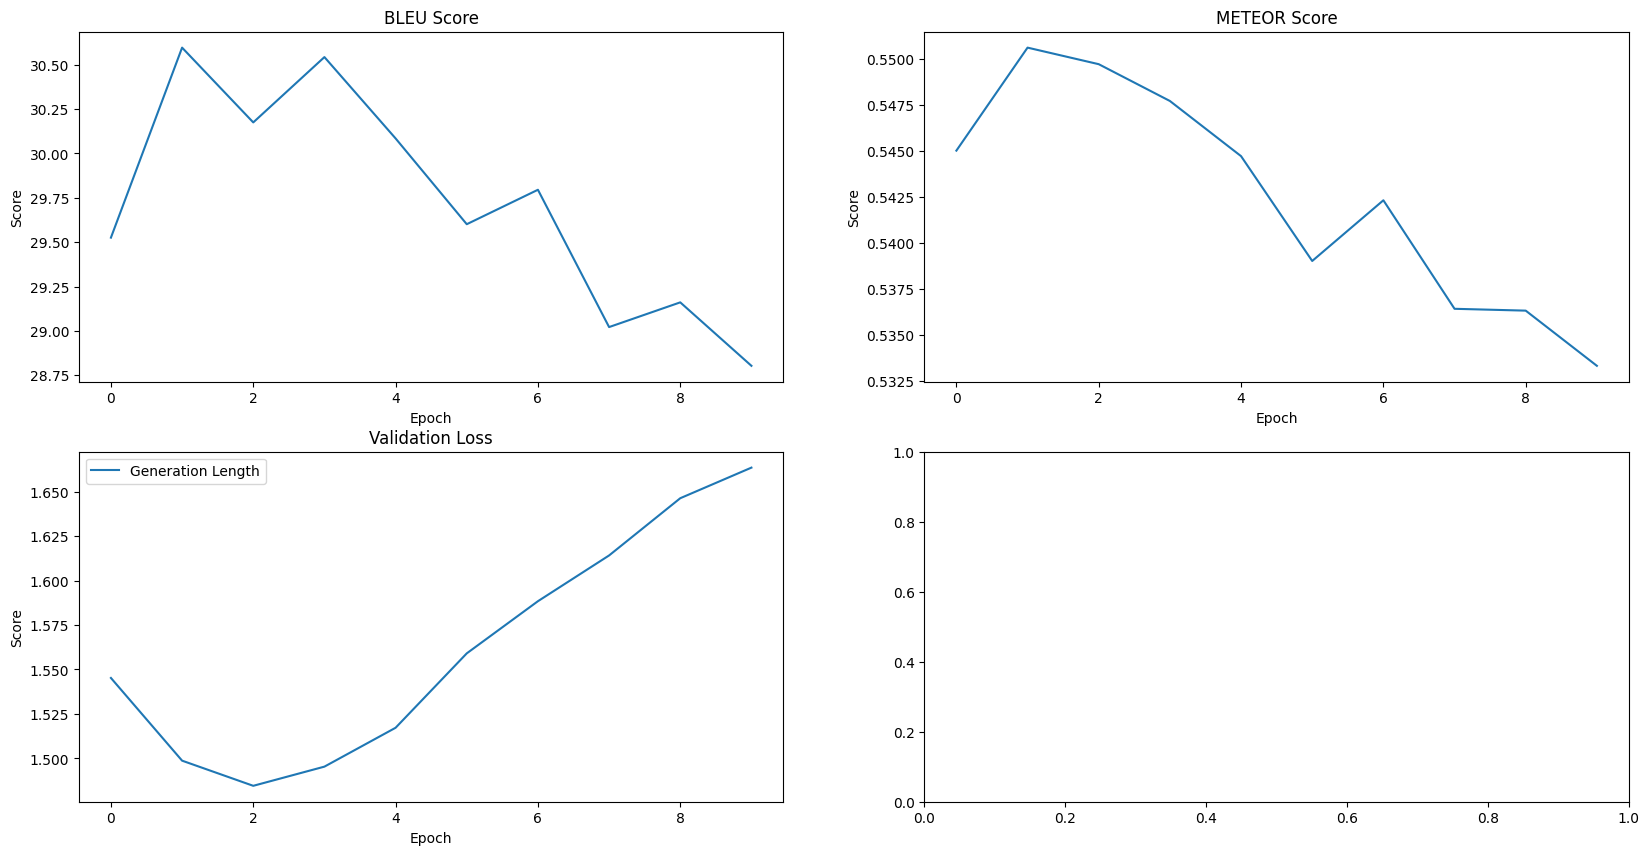

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(20,10))
plt.subplot(2, 2, 1)
plt.plot(range(len(bleu_log)), bleu_log, label='BLEU Score')
plt.title("BLEU Score")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.subplot(2, 2, 2)
plt.plot(range(len(meteor_log)), meteor_log, label='METEOR Score')
plt.title("METEOR Score")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.subplot(2, 2, 3)
plt.plot(range(len(eval_log)), eval_log, label='Generation Length')
plt.title("Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.legend()
plt.show()

In [14]:
import csv
rows = []
for i in range(len(bleu_log)):
    row = {
        'Epoch': i+1,
        'BLEU': bleu_log[i],
        'METEOR': meteor_log[i],
        'validation_loss': eval_log[i],
    }
    rows.append(row)

# Define the fieldnames for the CSV file
fieldnames = ['Epoch', 'BLEU', 'METEOR', 'validation_loss']

# Write the rows to a CSV file
with open('mBART.csv', 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for row in rows:
        writer.writerow(row)